## RandomForestClassifier deal_stage

In [73]:
# Importation des bibliothèques nécessaires
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss

In [74]:
# Charger les données
chemin = "C:/Users/zineb/OneDrive/Bureau/hetic/DA/silver/data_clean.csv"
df = pd.read_csv(chemin)





In [75]:

# 2. Préparation des données

# Gérer les valeurs manquantes
# Remplacer les virgules par des points si nécessaire
df['revenue'] = df['revenue'].str.replace(',', '.', regex=True)

# Convertir la colonne revenue en type float
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce').astype(float)


# verification des colonnes engage_at et close_at sont au format datetime
df['engage_at'] = pd.to_datetime(df['engage_at'], errors='coerce')
df['close_at'] = pd.to_datetime(df['close_at'], errors='coerce')

# Remplir les valeurs de close_value avec 0 pour les états engaging, prospecting, et lost
df.loc[df['deal_stage'].isin(['engaging', 'prospecting', 'lost']), 'close_value'] = 0



# Calculer la marge commerciale (sales_margin)
df['sales_margin'] = df.apply(
    lambda row: 0 if row['close_value'] == 0 else row['close_value'] - row['sales_price'],
    axis=1
)


# Calcul de la durée du cycle de vente (sales_cycle_days)
df['sales_cycle_days'] = (df['close_at'] - df['engage_at']).dt.days



# Vérifier les valeurs manquantes dans sales_margin
print("Nombre de NaN dans sales_margin avant traitement :", df['sales_margin'].isnull().sum())

# Remplacer les NaN dans sales_margin par 0
df['sales_margin'] = df['sales_margin'].fillna(0)


# Vérifier à nouveau pour s'assurer qu'il n'y a plus de NaN
print("Nombre de NaN dans sales_margin après traitement :", df['sales_margin'].isnull().sum())


# Afficher les premières lignes pour vérifier
print(df[['close_value', 'sales_price', 'sales_margin', 'sales_cycle_days']].head())
df = df.dropna(subset=['sales_margin'])



# Créer des colonnes temporelles dérivées
df['engage_year'] = df['engage_at'].dt.year
df['engage_month'] = df['engage_at'].dt.month
df['engage_day'] = df['engage_at'].dt.day
df['engage_weekday'] = df['engage_at'].dt.weekday  # Lundi=0, Dimanche=6

df['close_year'] = df['close_at'].dt.year
df['close_month'] = df['close_at'].dt.month
df['close_day'] = df['close_at'].dt.day
df['close_weekday'] = df['close_at'].dt.weekday

# Calculer la durée entre "engage_at" et "close_at" si applicable
df['sales_cycle_days'] = (df['close_at'] - df['engage_at']).dt.days

# Remplir les valeurs manquantes

df['sales_cycle_days'] = df['sales_cycle_days'].fillna(0)







Nombre de NaN dans sales_margin avant traitement : 664
Nombre de NaN dans sales_margin après traitement : 0
   close_value  sales_price  sales_margin  sales_cycle_days
0          0.0          550           0.0               7.0
1          0.0          550           0.0              13.0
2          0.0          550           0.0              69.0
3          0.0          550           0.0               2.0
4          0.0          550           0.0               2.0


C:\Users\zineb\AppData\Local\Temp\ipykernel_40032\2760569031.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['engage_at'] = pd.to_datetime(df['engage_at'], errors='coerce')
C:\Users\zineb\AppData\Local\Temp\ipykernel_40032\2760569031.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['close_at'] = pd.to_datetime(df['close_at'], errors='coerce')


In [76]:
df.columns

Index(['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage',
       'engage_at', 'close_at', 'close_value', 'sector', 'series',
       'sales_price', 'manager', 'office_location', 'regional_office',
       'year_founded_at', 'revenue', 'number_of_employees', 'sales_margin',
       'sales_cycle_days', 'engage_year', 'engage_month', 'engage_day',
       'engage_weekday', 'close_year', 'close_month', 'close_day',
       'close_weekday'],
      dtype='object')

In [77]:

# Vérifier les types de données
print("Types des données avant encodage :\n", df.dtypes)

# Encoder les colonnes catégoriques avec LabelEncoder
label_encoders = {}
cat_columns = ['sales_agent', 'product', 'account', 'sector', 'series', 'manager', 'office_location', 'regional_office', 'deal_stage']

for col in cat_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print("Types des données après encodage :\n", df.dtypes)



Types des données avant encodage :
 opportunity_id                 object
sales_agent                    object
product                        object
account                        object
deal_stage                     object
engage_at              datetime64[ns]
close_at               datetime64[ns]
close_value                   float64
sector                         object
series                         object
sales_price                     int64
manager                        object
office_location                object
regional_office                object
year_founded_at                 int64
revenue                       float64
number_of_employees             int64
sales_margin                  float64
sales_cycle_days              float64
engage_year                   float64
engage_month                  float64
engage_day                    float64
engage_weekday                float64
close_year                    float64
close_month                   float64
close_day     

In [78]:
# Remplir les valeurs manquantes dans les colonnes numériques
df['close_value'] = df['close_value'].fillna(0)
df['sales_margin'] = df['sales_margin'].fillna(0)


In [79]:
df.columns

Index(['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage',
       'engage_at', 'close_at', 'close_value', 'sector', 'series',
       'sales_price', 'manager', 'office_location', 'regional_office',
       'year_founded_at', 'revenue', 'number_of_employees', 'sales_margin',
       'sales_cycle_days', 'engage_year', 'engage_month', 'engage_day',
       'engage_weekday', 'close_year', 'close_month', 'close_day',
       'close_weekday'],
      dtype='object')

In [80]:
# Définir les caractéristiques (X) et la cible (y)


X = df.drop(columns=[ 'deal_stage', 'close_value', 'year_founded_at',
       'engage_at','close_at', 'sales_margin', 'sales_cycle_days','engage_year',
       'opportunity_id','year_founded_at' , 'manager','close_year', 'close_month', 'close_day', 'close_weekday'
       ])
y = df['deal_stage']

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [81]:
X.columns

Index(['sales_agent', 'product', 'account', 'sector', 'series', 'sales_price',
       'office_location', 'regional_office', 'revenue', 'number_of_employees',
       'engage_month', 'engage_day', 'engage_weekday'],
      dtype='object')

In [82]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [83]:
# Créer et entraîner le modèle
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)




RandomForestClassifier(random_state=42)

In [84]:
# Prédictions
y_pred = rf_model.predict(X_test)



In [85]:
# Évaluation
print("\nRapport de classification pour la prédiction du deal_stage :")
print(classification_report(y_test, y_pred))
print("Précision globale :", accuracy_score(y_test, y_pred))





Rapport de classification pour la prédiction du deal_stage :
              precision    recall  f1-score   support

           0       0.80      0.04      0.07       110
           1       0.39      0.19      0.26       519
           2       1.00      1.00      1.00        36
           3       0.57      0.82      0.67       810

    accuracy                           0.55      1475
   macro avg       0.69      0.51      0.50      1475
weighted avg       0.53      0.55      0.49      1475

Précision globale : 0.5484745762711865


In [86]:
# Visualisation des importances des caractéristiques
feature_importances = rf_model.feature_importances_
feature_names = X.columns  # Extraire dynamiquement les noms des colonnes



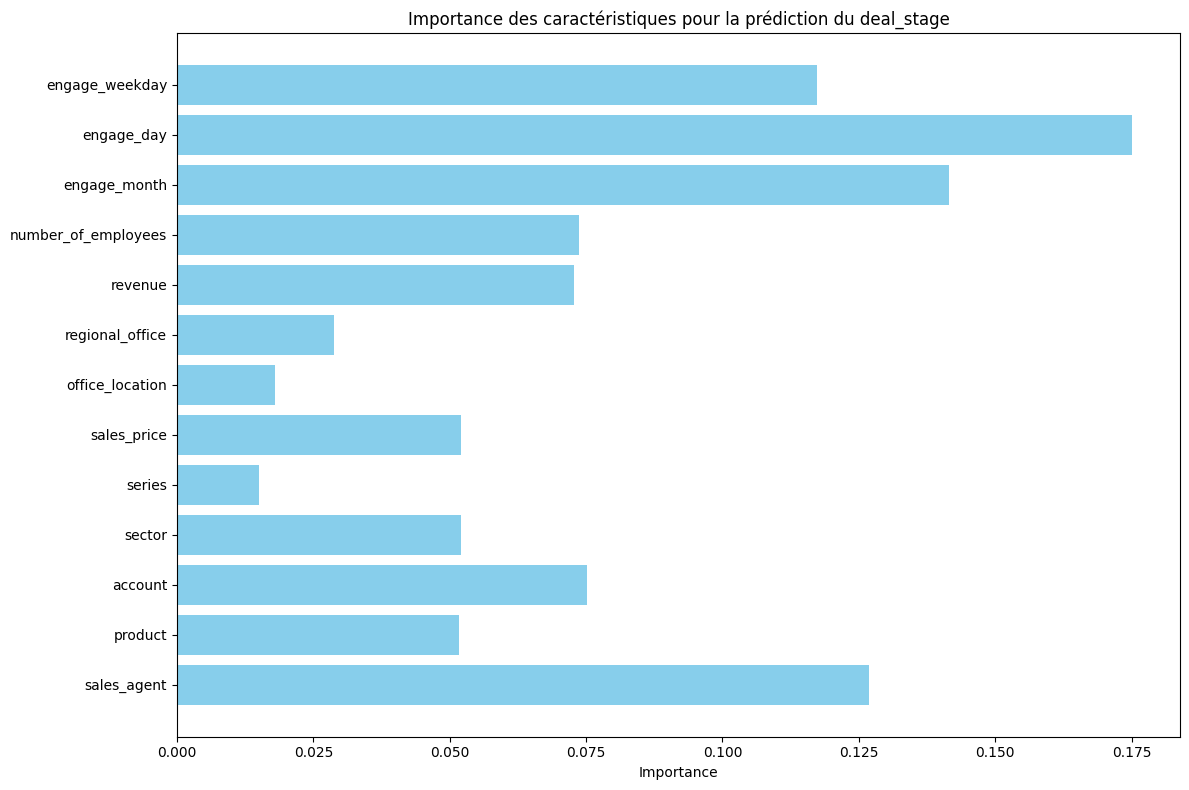

In [87]:
# Afficher les importances des caractéristiques
plt.figure(figsize=(12, 8))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel("Importance")
plt.title("Importance des caractéristiques pour la prédiction du deal_stage")
plt.tight_layout()
plt.show()



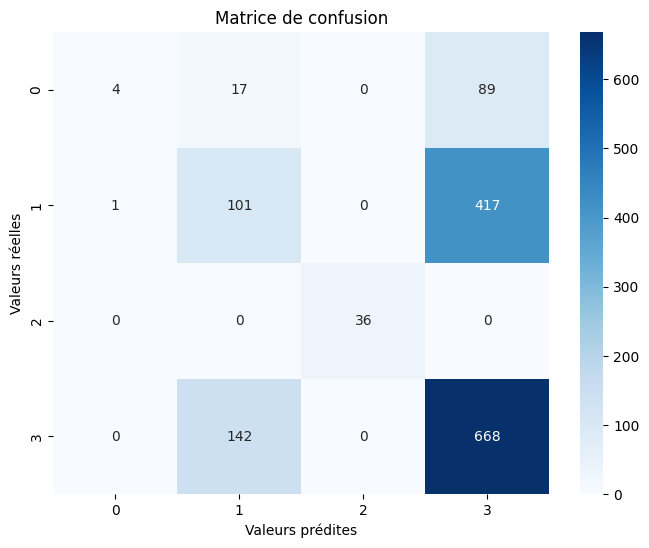

In [88]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()



In [89]:
# Validation croisée
cv_scores = cross_val_score(rf_model, X_scaled, y, cv=5)
print("\nScores de validation croisée :", cv_scores)
print("Précision moyenne (validation croisée) :", np.mean(cv_scores))




Scores de validation croisée : [0.06983051 0.07457627 0.17220339 0.02779661 0.02508475]
Précision moyenne (validation croisée) : 0.07389830508474576


In [90]:

# Encodage des classes en valeurs numériques pour log loss
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)
y_pred_proba = rf_model.predict_proba(X_test)

# Log Loss
log_loss_value = log_loss(y_test_encoded, y_pred_proba)
print("\nLog Loss :", log_loss_value)


Log Loss : 0.8787756486613649
